# Clustering the $\epsilon=18$ Trajectory

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import MDAnalysis as md
from shapeGMMTorch import torch_sgmm
import torch

## Read trajectory

In [2]:
prmtopFileName = "../../cluster1.pdb"
traj1FileName = "../run_files_eps18_cluster1/helix_folding_eps18.0.dcd"
traj2FileName = "../run_files_eps18_cluster2/helix_folding_eps18.0.dcd"
coord = md.Universe(prmtopFileName,traj1FileName,traj2FileName)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
atomSel = coord.select_atoms('all')
print("Number of atoms in selection:", atomSel.n_atoms)
# create traj data of selection
traj_data = np.empty((coord.trajectory.n_frames,atomSel.n_atoms,3),dtype=float)
#loop traj
for ts in coord.trajectory:
    traj_data[ts.frame,:] = atomSel.positions

Number of atoms in trajectory: 12
Number of frames in trajectory: 200002
Number of atoms in selection: 12


## Perform Cross Validation with Uniform Weights

In [3]:
# scripts contains a built-in CV routine
from shapeGMMTorch import scripts

Here we will perform a cluster scan assuming each frame has the same weight.  This is exactly what we did in the other notebook.

In [4]:
# define cluster array
cluster_array = np.arange(1,5,1).astype(int)

In [5]:
# uniform weights
train, cv = scripts.cross_validate_cluster_scan(traj_data, 10000, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=3, n_attempts = 5, dtype=torch.float32, device=torch.device("cpu"))

Number of frames to train each model: 10000
Number of frames to predict each model: 190002
Number of training sets: 3
Number of clusters: 4
Number of attempts per set/cluster: 5
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1              51.468          81.316
              1               2               1              52.376          31.128
              1               2               2              56.980           7.790
              1               2               3              56.976          23.013
              1               2               4              56.980           7.799
              1               2               5              56.980           7.982
              1               3               1              57.965          12.538
              1               3               2              57.9

### Save and load log likelihood data for quick use

In [6]:
# save data (optional - don't have to do this)
np.savetxt("eps18_ll_train.dat", train)
np.savetxt("eps18_ll_cv.dat", cv)

In [ ]:
# load data
# NOTE - only do this if you want to overwrite active arrays
train = np.loadtxt("eps18_ll_train.dat")
cv = np.loadtxt("eps18_ll_cv.dat")

## Make Log Likelihood vs number of Cluster Plots

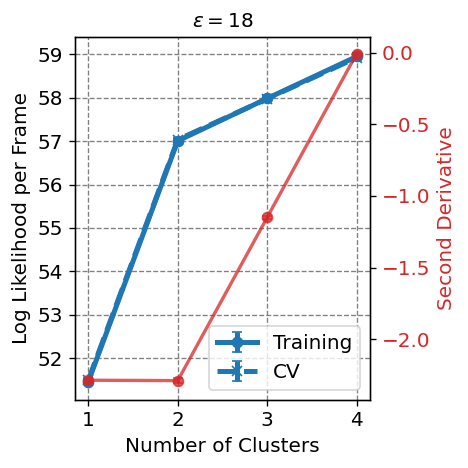

In [7]:
# shapeGMMTorch plots has a built-in plot function for this type of plot
from shapeGMMTorch import plots
# also need to load matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# create figure
fig, ax = plt.subplots(1,1,figsize=(4,4), dpi= 120, facecolor='w', edgecolor='k',sharex=True,sharey=True)
# Uniform Weights
ax.set_title("$\epsilon=18$",fontsize=12)
plots.plot_log_likelihood_with_dd(ax,cluster_array,train,cv,fontsize=12,ylabel1=True,ylabel2=True,xlabel=True)
# show plot
plt.tight_layout()
plt.show()

## Fit a $n_{clusters}=2$ object with ENM weights

In [8]:
# fit a shapeGMM object for n=2 with ENM weights trained on every other frame
# shapeGMMTorch has a built-in script for this
sgmm_eps18 = scripts.sgmm_fit_with_attempts(traj_data, 2, 10, frame_weights=np.ones(traj_data.shape[0]),device=torch.device("cpu"),dtype=torch.float64)

Number of training frames: 200002
Number of clusters: 2
Number of attempts: 10
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              57.048         112.555
       2              57.045         294.189
       3              52.774        2324.331
       4              57.044         229.686
       5              57.048         121.058
       6              57.048         118.907
       7              57.048         119.093
       8              57.048         120.104
       9              57.044         410.918
      10              57.048         120.304


In [9]:
print(sgmm_eps18.weights)

[0.5 0.5]


In [10]:
# save pickled object
import pickle
file_obj = open("eps18_2clusters.pickle","wb")
pickle.dump(sgmm_eps18,file_obj)
file_obj.close()